In [136]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Length based data

In [137]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)



################################################################
# load data and data normalization
################################################################

inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0

n_data = output.shape[1]
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
output_loss = -np.dot(xx_mask, output) * L_x/N_s




In [138]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :]
A[:, 2] = inputPara[5, :]
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [   5993.73724467   -8682.17376047    2475.9614333   -48534.09494157
 1114448.7126439 ]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


0.12406422986004143

In [139]:
output_loss.shape

(1000,)

In [140]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :] - inputPara[2, :]/2.0
A[:, 2] = inputPara[5, :] - inputPara[2, :]/2.0
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [   2890.63108109   -8682.17376047    2475.9614333   -48534.09494157
 1114448.7126439 ]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # Remove the CWD from sys.path while we load stuff.


0.12406422986004143

In [141]:
# fno model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)

print(count_params(model))
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)

ntrain = n_data
x_train = input.to(device).reshape(ntrain, N_s, 2)
pred = np.zeros((n_data, N_s))
for i in range(n_data):
    # pred[i, :] = torch.clip(model(x_train[i:i+1,:,:]).squeeze(), min=0.0).detach().cpu().numpy()
    # pred[i, :] = torch.clip(model(x_train[i:i+1,:,:].to(device)), min=0.0).detach().cpu().numpy().flatten()
    # pred[i, :] = torch.abs(model(x_train[i:i+1,:,:].to(device))).detach().cpu().numpy().flatten()
    pred[i, :] = model(x_train[i:i+1,:,:].to(device)).detach().cpu().numpy().flatten()
    
    
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
fno_loss = -np.dot(pred, xx_mask) * L_x/N_s

print("FNO mean loss error: ",  np.mean(  np.abs(fno_loss - output_loss) / output_loss  ) )
print("FNO max loss error: ",  np.max(  np.abs(fno_loss - output_loss) / output_loss  ) )



1336001
FNO mean loss error:  0.010087278051660533
FNO max loss error:  0.09326612241990612


In [142]:
fno_loss_min_ind = np.argmin(fno_loss)
print("fno min = ", fno_loss[fno_loss_min_ind], " at ", fno_loss_min_ind)
print("sample, uf, L_p, x1, x2, x3, h = ", inputPara[:, fno_loss_min_ind])
print("truth eval = ", output_loss[fno_loss_min_ind])
print("error = ", np.abs((fno_loss[fno_loss_min_ind] - output_loss[fno_loss_min_ind])/output_loss[fno_loss_min_ind]))

loss_min_ind = np.argmin(output_loss)
print("truth min = ", output_loss[loss_min_ind], " at ", loss_min_ind)
print("sample, uf, L_p, x1, x2, x3, h = ", inputPara[:, loss_min_ind])
print("fno eval = ", fno_loss[loss_min_ind])
print("error = ", np.abs((fno_loss[loss_min_ind] - output_loss[loss_min_ind])/output_loss[loss_min_ind]))


fno min =  257745.56280213592  at  784
sample, uf, L_p, x1, x2, x3, h =  [785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
truth eval =  262913.03325813607
error =  0.019654675890208056
truth min =  262913.03325813607  at  784
sample, uf, L_p, x1, x2, x3, h =  [785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
fno eval =  257745.56280213592
error =  0.019654675890208056


290481.6204417052


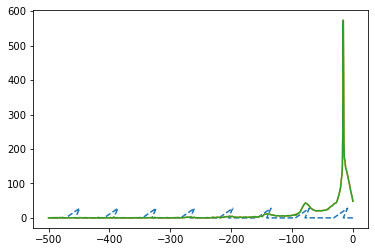

In [106]:
# L_p, x2, x3, h
# fix L_p, h
sample, uf, L_p, x1, x2, x3, h = inputPara[:, fno_loss_min_ind]
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)


X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

X_Y = x_train[fno_loss_min_ind:fno_loss_min_ind+1,:,:]
out = torch.abs(model(X_Y).squeeze()).detach().cpu().numpy()
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = -np.dot(out, xx_mask)* L_x/N_s
plt.plot(xx_mask, out)
plt.plot(xx_mask, out)
print(loss)

In [107]:
# L_p, x2, x3, h
# fix L_p, h
L_p, h = 61.0,  30.0
L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

# 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
nx2, nx3 = 60*2+1, np.int64((L_p/2-15)*2+1)
x2_range = np.linspace(-L_p, 0.0, nx2)
x3_range = np.linspace(-L_p/2+15, 0.0, nx3)
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(x3_range)))
for i in range(len(x2_range)):
    for j in range(len(x3_range)):
        x2, x3 = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(x3_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        
        out = torch.abs(model(X_Y).squeeze()).detach().cpu().numpy()
                
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        

(-30.0, 0.0)

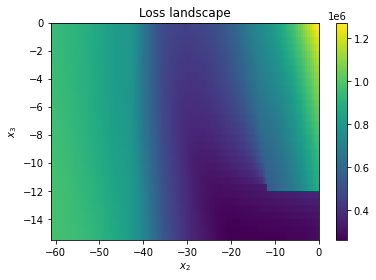

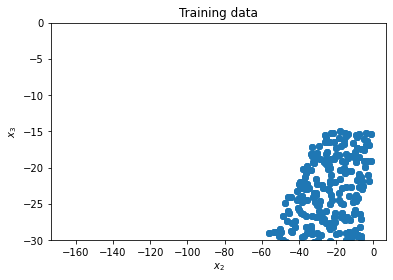

In [108]:
X, Y = np.meshgrid(x2_range ,x3_range)
plt.pcolormesh(X, Y, loss.transpose())
plt.colorbar()
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Loss landscape")


plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Training data")
plt.ylim([-30, 0])

In [109]:
# L_p, x2, x3, h
# fix L_p, h

x3, h = -15.5,  30.0
x3, h =  torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

# 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
nx2, nx3 = 60*2+1, np.int64((L_p/2-15)*2+1)
Lp_range = np.linspace(61, 249, 188*2 + 1)
x2_range = np.linspace(-249, 0, 249*2 + 1)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(Lp_range)))
for i in range(len(x2_range)):
    for j in range(len(Lp_range)):
        if Lp_range[j] + x2_range[i] < 0.0:
            loss[i,j] = np.NaN
        else:
            x2, Lp = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(Lp_range[j], dtype=torch.float)
            X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

            out = torch.abs(model(X_Y).squeeze()).detach().cpu().numpy()
            loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        
        
        

Text(0.5, 1.0, 'Training data')

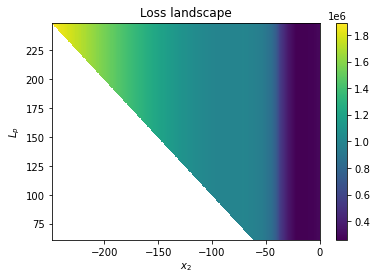

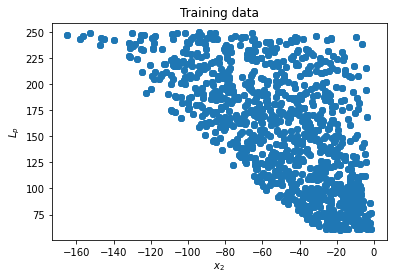

In [110]:
X, Y = np.meshgrid(x2_range ,Lp_range)
plt.pcolormesh(X, Y, loss.transpose())
plt.colorbar()
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Loss landscape")


plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Training data")
# plt.ylim([-30, 0])

sum =  2799.364882352539
dx2_x1 =  5  loss =  255175.6075719778
sum =  2289.896807639795
dx2_x1 =  10  loss =  227980.44721974965
sum =  2039.2285318814027
dx2_x1 =  15  loss =  213658.09801476402
sum =  1945.2794734523154
dx2_x1 =  20  loss =  214384.4063785294
sum =  2195.1462626454722
dx2_x1 =  25  loss =  234873.56951246053
sum =  2367.489784163824
dx2_x1 =  28  loss =  256646.07476506257
sum =  2528.150900401163
dx2_x1 =  30  loss =  268334.41000783106


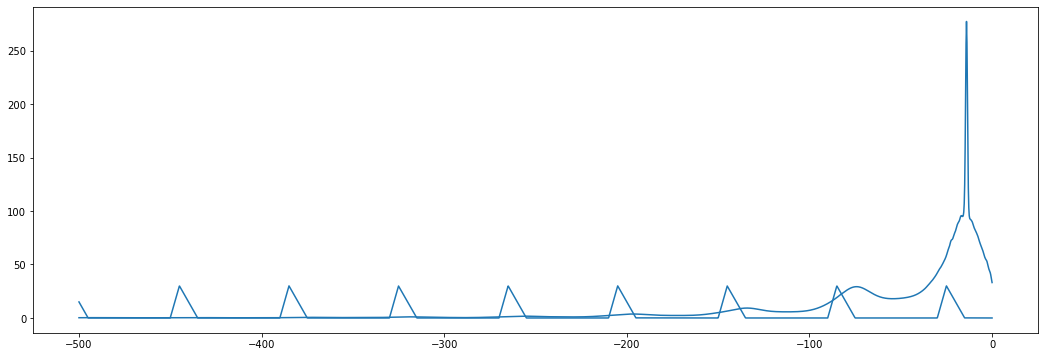

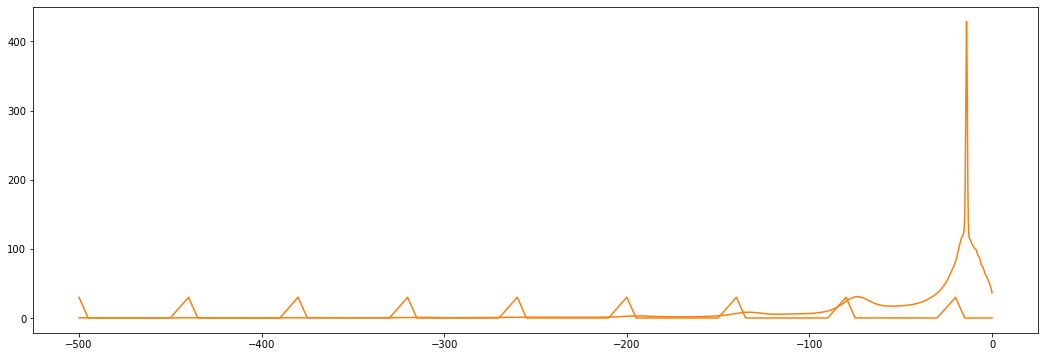

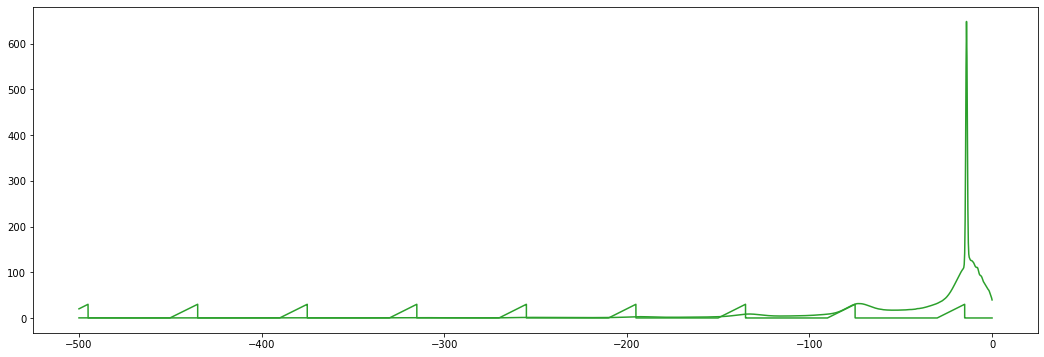

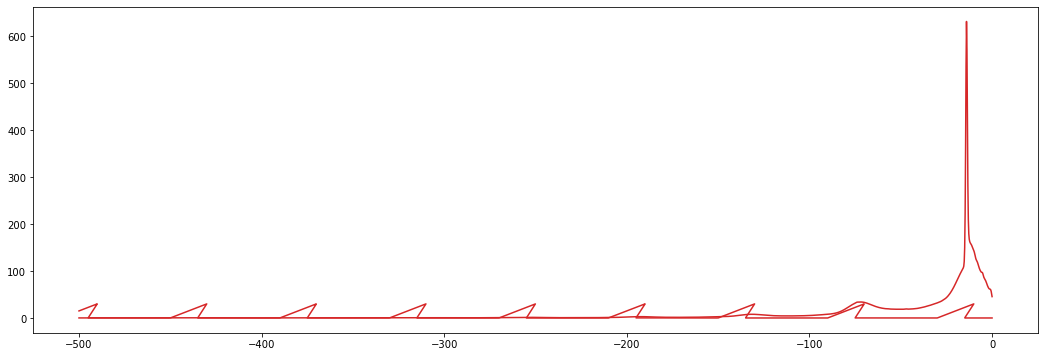

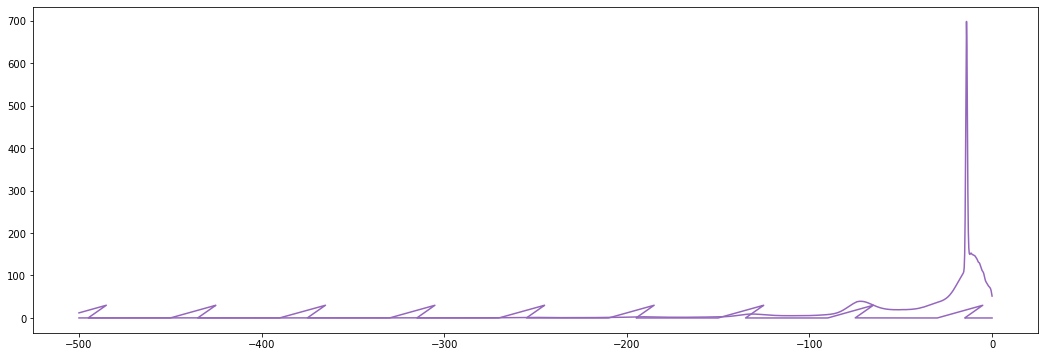

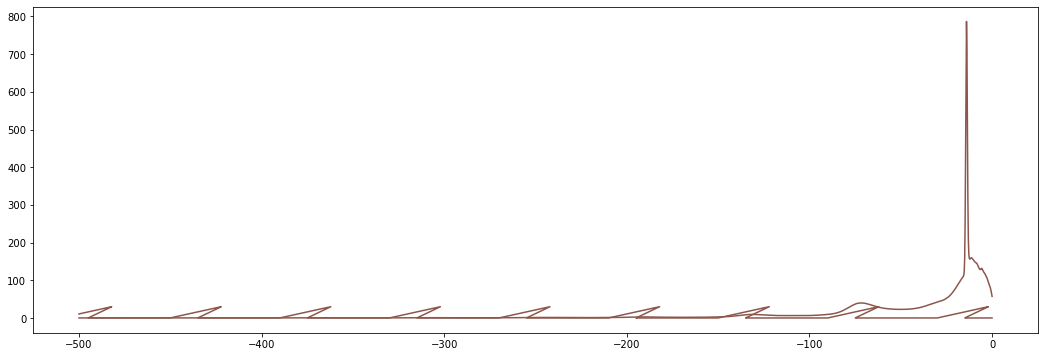

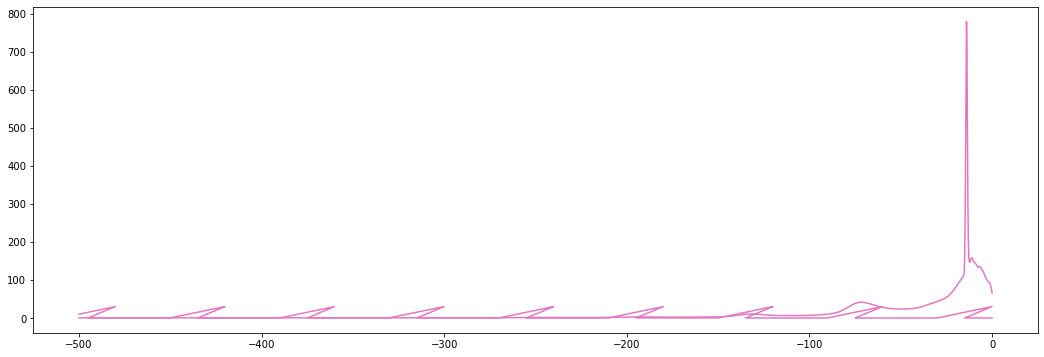

In [111]:
train_data_folder = "/home/tingtaoz/storage/traindatalevy/optimizedtests0906/"

# Study the effect of bw_method
t = 9


N_s, L_x = 2001, 500
L_p, x1, x3, h = 60.0, -30.0, -15, 30.0
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
dx2_x1_list = np.array([5, 10, 15, 20, 25, 28, 30])
true_loss = np.zeros(len(dx2_x1_list))
x_mesh, y_mesh = np.zeros((len(dx2_x1_list), N_s)), np.zeros((len(dx2_x1_list), N_s))
density_1d_data_all = np.zeros((len(dx2_x1_list), N_s, 3))
density_1d_data = np.zeros((len(dx2_x1_list), N_s))
for i in range(len(dx2_x1_list)):
    dx2_x1 = dx2_x1_list[i]
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x1+dx2_x1, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/x2_"+str(dx2_x1)+"_U020uf*")
    for file_name in file_names:
        
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)
    print("sum = ", sum(density_1d_data[i, 0:1600]))
    true_loss[i] = -np.dot(density_1d_data[i, :], xx)* L_x/N_s
    
    print("dx2_x1 = ",dx2_x1, " loss = ", -np.dot(density_1d_data[i, :], xx)* L_x/N_s)
    
    plt.figure(figsize=(18,6))
    plt.plot(xx,  density_1d_data[i, :], color="C"+str(i))
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C"+str(i))


loss =  [739793.58332575 740257.36605315 742175.89398463 744280.22969989
 745529.58229678 744613.8151935  743189.85021382 741779.84997887
 741115.10887124 740356.79415837 737745.1084737  734288.88668966
 729322.23567221 723292.98212428 716246.39221169 707272.71595177
 694945.9750668  679953.98021339 663958.41712049 647527.47082078
 630522.11085374 612765.40777033 592750.71855277 571813.94286588
 550800.39759112 529044.81680175 507550.95918559 486768.48299676
 466200.20140213 445331.99555688 423871.31470306 402574.56672465
 381651.03445879 361150.90147985 341652.850303   323545.09521904
 307368.43232556 293113.49375713 280215.89301719 268452.60915193
 258549.83491233 250284.80631259 243612.411597   238525.50812316
 234681.4807498  232134.43479534 230599.99949545 229174.14473607
 228579.79635823 229037.76242643 230720.24616479 233392.98096569
 237303.67001353 242572.1789612  249166.61296243 257034.70251847
 266968.2804555  278364.9842783  290313.33577837 302283.23502193
 313948.53875818]

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


loss =  [736001.91204782 736320.20243802 736216.74745206 735385.91445277
 735458.5372177  736401.44707591 736594.77831912 736820.53893691
 738028.88088973 736972.61590942 733784.26392165 730459.8472373
 725543.1477517  718664.07113373 708488.21572938 697569.95642324
 685757.96169008 672160.18321276 657543.47653272 642381.00937083
 625224.66376641 605881.77372754 584425.21425191 561712.63127518
 539233.64256399 516441.57942953 493983.88011257 471802.9682802
 449741.17755124 427295.13278276 405106.8290126  383461.70026026
 361769.07742465 340614.23397298 321155.27390998 303207.41687259
 286746.29383862 271508.92784631 257553.92225717 245750.46167619
 235762.54034064 227760.27978814 221975.48742982 217992.3199572
 214569.99812581 211406.99653528 208759.8353579  207775.67537222
 208007.80696363 209422.87308845 211694.356725   214887.73936778
 219247.16478954 224958.2539672  231956.36664709 239931.19295741
 248767.02762133 258643.93259047 269242.89797181 279949.36392721
 290664.83844583]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


loss =  [722522.5029208  722431.37071197 723948.31928516 725653.87689925
 726652.69917016 726894.11779648 727060.96085025 727717.35942952
 728076.45923154 728295.01628557 726876.7899858  722612.94885915
 716390.18875054 709601.64366683 702158.39143008 694392.81170348
 685485.45872173 673483.450456   657044.18079047 637773.06230202
 614688.75092293 587497.34194641 558789.77978917 530095.5590948
 503135.13807421 477381.66292046 450944.64936813 423927.12601477
 397028.34507248 370475.13651743 345070.66026685 321455.22773812
 300440.07449275 281802.8131104  265160.49415435 249009.29224046
 234757.49994717 225524.19685026 222467.19061742 228758.99487325
 244846.60070673 253708.45324523 262780.33917563 273374.80058825
 289514.99569599 308069.5622657  326604.93411312 345331.56391261
 366095.1052229  387209.25743397 409014.72694506 431087.22706689
 454335.95409077 479927.82084779 505324.68807352 529964.58776819
 554220.36148041 577794.67837528 600941.8277829  624079.53534815
 646746.76771567]


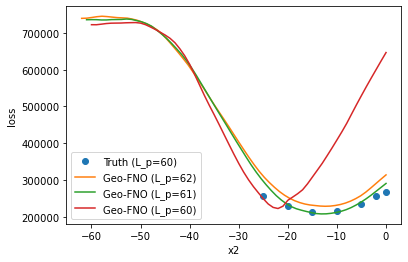

In [143]:
# This is for L_p = 60, x_3 = 15
ax = plt.subplot(111)
ax.plot(-L_p/2 + dx2_x1_list, true_loss,  "o", label="Truth (L_p=60)")
x3 = -15
# L_p, x2, x3, h
# fix L_p, h
for L_p in [62, 61, 60]:
    h = 30.0
    L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

    # 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
    nx2 = 60+1
    x2_range = np.linspace(-L_p, 0.0, nx2)
    x3 = torch.tensor(x3, dtype=torch.float)
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    loss = np.zeros(len(x2_range))
    for i in range(len(x2_range)):
        x2 = torch.tensor(x2_range[i], dtype=torch.float)

        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

        out = model(X_Y).squeeze().detach().cpu().numpy()
        #out = torch.clip(model(X_Y).squeeze(), 0.0).detach().cpu().numpy()

        loss[i] = -np.dot(out, xx_mask)* L_x/N_s
        
    print("loss = ", loss)
    ax.plot(x2_range, loss, label=r"Geo-FNO (L_p=%d)" %L_p)

ax.set_xlabel("x2")
ax.set_ylabel("loss")
ax.legend()

/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf10.0906alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf5.04531alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf15.1359alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf10.0906alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf15.1359alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf5.04531alpha1.5tauR2_13.2834_15.0299_28.3752.h5
dx2_x1 =  30  loss =  272731.6552793368


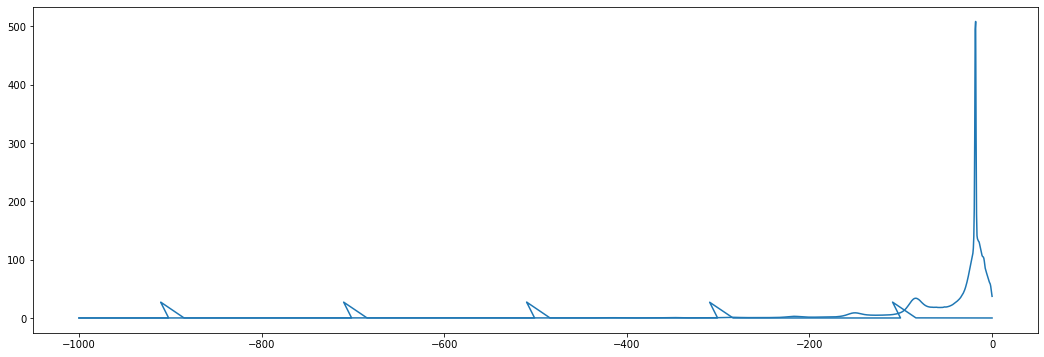

In [113]:
train_data_folder = "/home/tingtaoz/storage/traindatalevy/allparams/0823/"
info_file = "/home/tingtaoz/storage/traindatalevy/allparams/0823/params.txt"
data_info = np.genfromtxt(info_file, delimiter=',', skip_header=1)
# Study the effect of bw_method
t = 9


N_s, L_x = 2001, 1000
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
samples = [633,]

x_mesh, y_mesh = np.zeros((len(samples), N_s)), np.zeros((len(samples), N_s))
density_1d_data_all = np.zeros((len(samples), N_s, 3))
density_1d_data = np.zeros((len(samples), N_s))
for i in range(len(samples)):
    L_p, x2, x3, h, press = data_info[i - 1, :]
    x1 = -0.5*L_p
    x2 = x1 + x2
    x3 = x1 + x3
    
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/sample"+str(samples[i])+"_U020uf*")
    for file_name in file_names:
        
        print(file_name)
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)

    print("dx2_x1 = ",dx2_x1, " loss = ", -np.dot(density_1d_data[i, :], xx)* L_x/N_s)
    plt.figure(figsize=(18,6))
    plt.plot(xx,  density_1d_data[i, :], color="C"+str(i))
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C"+str(i))

# # density 
# plt.figure()
# plt.plot(xx,  density_1d_data)
# plt.plot(x_mesh, y_mesh, color="red")

# # density 
# plt.figure()
# plt.hist(x_b,  bins = 100)
# plt.plot(x_mesh, y_mesh, color="red")
